In [1]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352616446/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## TO DOs
* ~~import CelebA .csv~~
* ~~compute percentage of men and women for any other categories~~
    * ~~visualisation~~
* ~~compute distribution of our ranking score for every category~~
    * ~~visualisation~~
* ~~print the top 36 images~~
* ~~import features space after TSNE~~
    * ~~print such a space with points colored with a heatmap according with the ranking score~~
* import the result of partial clustering 
    * print the centroid for every cluster

In [3]:
# paths 
celebA_csv = "../data/celeba/list_attr_celeba.csv"
results_folder = "../results"
models_folder = results_folder + "/Results_CelebA_ResNet18/input_dim_1000" +\
                "/init_trunc_inv_sqrt/layers_3/neuron_1024/" +\
                "lambda_cvx_0.1_mean_0.0/" +\
                "optim_Adamlr_0.001betas_0.5_0.99/gen_16/batch_25/" +\
                "trial_1_last_inp_qudr/storing_models"

In [4]:
# other inputs
# final epoch of ICNN training
final_epoch = 14

# GPU acceleration
cuda = torch.cuda.is_available()
mps = torch.backends.mps.is_available()

In [5]:
cuda

False

In [6]:
# import celebA data
df = pd.read_csv(celebA_csv)

df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values_resnet18
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,1.558925e+06
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,9.668824e+03
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,3.633366e+06
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,8.897842e+05
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2.429512e+06


In [7]:
# import feature extractor
#features = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

We compute the percentage of men and women for each attribute in CelebA.

In [31]:
# for every attribute, compute the percentage of men and women with that attribute
n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Male" : n_male_col/n_male,
                 "Female" : n_female_col/n_female}

bias.pop("image_id")
bias.pop("Male")

{'Male': 1.0, 'Female': 0.0}

In [9]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))

In [67]:
# save the barplots
for col, values in bias.items():
    make_barplot(results_folder + "/barplots_celeba", col, values)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [66]:
bias.items()

dict_items([('5_o_Clock_Shadow', {'Male': 0.26643295354951796, 'Female': 0.0001692548554986671}), ('Arched_Eyebrows', {'Male': 0.05345003197763934, 'Female': 0.419557398552871}), ('Attractive', {'Male': 0.27925953999573633, 'Female': 0.6791689586595016}), ('Bags_Under_Eyes', {'Male': 0.3482483359783973, 'Female': 0.10190834849574747}), ('Bald', {'Male': 0.053651372669777576, 'Female': 0.00014386662717386705}), ('Bangs', {'Male': 0.08231281237416206, 'Female': 0.20106630558964161}), ('Big_Lips', {'Male': 0.15608641068763768, 'Female': 0.30132441924427705}), ('Big_Nose', {'Male': 0.4196295331264656, 'Female': 0.1022722464350696}), ('Black_Hair', {'Male': 0.2979368500840893, 'Female': 0.19731731054034612}), ('Blond_Hair', {'Male': 0.020714404149986973, 'Female': 0.23893707950746837}), ('Blurry', {'Male': 0.05723997441788853, 'Female': 0.046367367663859856}), ('Brown_Hair', {'Male': 0.1514555747684582, 'Female': 0.24359158803368172}), ('Bushy_Eyebrows', {'Male': 0.24423810313380864, 'Femal

We compute the distribution of the ranking score for men and women with respect to each attribute.

In [11]:
# foo colums, to be replaced with the actual ranking score 
# df["foo"] = np.random.normal(size=len(df))

In [21]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    plt.savefig(path + "/{}.jpeg".format(col))
    #plt.show()

In [23]:
df_gender = df[df["Male"] == -1]

gender = "Female"
for col in bias.keys():
    make_histograms(results_folder + "/histograms_celeba", df=df_gender,
                    col=col, score="values_resnet18", gender=gender)
    plt.clf()

<Figure size 432x288 with 0 Axes>

We plot the top 36 images according to the ranking. 

In [24]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [28]:
img_ids = df[df["Male"] == -1].sort_values(by="values_resnet18", ascending=False)["image_id"][:36]
array_img_vectors = np.array(
    [skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
     for file in img_ids])

In [71]:
ind = df[df["Male"] == -1].sort_values(by="values_resnet18", ascending=False)["image_id"][:36].index
df[df["Male"] == -1].loc[ind, "Wearing_Hat"]

131667   -1
175536   -1
175614    1
160170   -1
184402   -1
202480    1
92609     1
101819   -1
6055     -1
169577   -1
49868    -1
201376   -1
38725     1
165940   -1
136662   -1
100303   -1
169046   -1
129333   -1
152605   -1
34854    -1
124638   -1
164918   -1
77685    -1
90661    -1
167462   -1
25391    -1
147296   -1
141922   -1
43035    -1
10485    -1
107649   -1
105052   -1
201075   -1
183725    1
1867     -1
28476    -1
Name: Wearing_Hat, dtype: int64

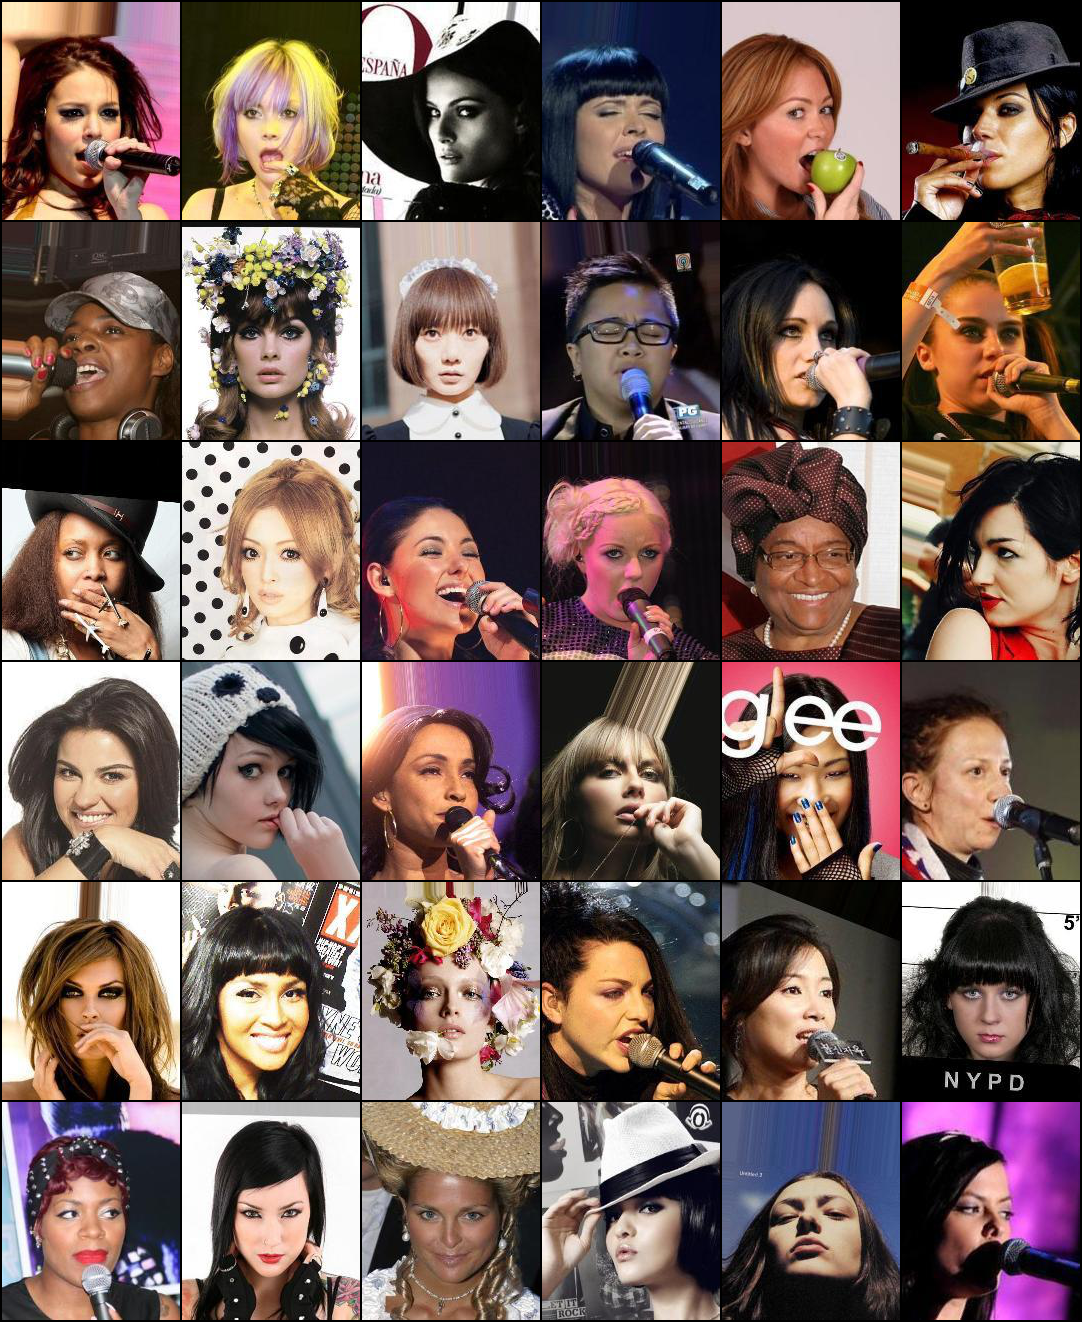

In [29]:
save_images_as_grid("", array_img_vectors)

We open the numpy array of our feature space

In [17]:
def open_array():
    pass

In [50]:
path_arr = '../results/Results_CelebA_ResNet18/input_dim_1000/init_trunc_inv_sqrt/layers_3/neuron_1024/lambda_cvx_0.1_mean_0.0/optim_Adamlr_0.001betas_0.5_0.99/gen_16/batch_25/trial_1_last_inp_qudr/feature_space.npy'
space = np.load(path_arr)
#space = np.random.randn(160, 512)

We plot the TSNE representation of our space. We distinguisce points sampled from the two distributions. The features extracted from female subjects are colered according to our ranking score.

In [46]:
def plot_tsne(path, array1, array2, scores):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray")
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r")
    plt.title("TSNE representation of the feature space")
    
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [47]:
sample = df.sample(10000)
sample_space = space[sample.index]
sample.reset_index(inplace=True)

sample_female = sample[sample["Male"] == -1].sample(500)
sample_female_score = sample_female["values_resnet18"].values
sample_female_array = sample_space[sample_female.index]


sample_male = sample[sample["Male"] == 1].sample(500)
sample_male_array = sample_space[sample_male.index]


tsne = TSNE()
transformed_space = tsne.fit_transform(sample_space)

/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


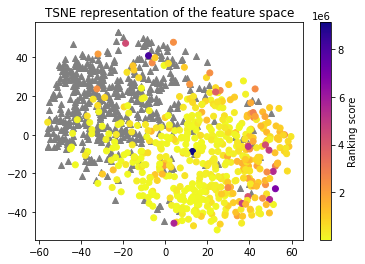

In [49]:
plot_tsne("",
          transformed_space[sample_male.index],
          transformed_space[sample_female.index],
          sample_female_score)

We cluster the features of the top 10% images according to the ranking and show the images that are the closest to the centroids. 

In [54]:
nintieth_quatile = df[df["Male"] == -1].values_resnet18.quantile(.9)

indeces = df[(df["Male"] == -1) & (df["values_resnet18"] >= nintieth_quatile)].index

to_cluster = space[indeces]

In [56]:
kmeans.cluster_centers_

array([[ 0.24542248,  1.3234451 ,  0.75425637, ..., -3.6656566 ,
         1.4433006 ,  3.4836373 ],
       [ 1.5903077 ,  0.7432894 ,  1.4207814 , ..., -3.3898478 ,
         1.194732  ,  2.8993895 ],
       [ 0.39759052,  0.8665465 ,  0.923121  , ..., -3.6218328 ,
         0.52789676,  2.7219548 ],
       ...,
       [ 2.9594417 ,  1.5846395 ,  2.2480414 , ..., -1.9001051 ,
         1.5228467 ,  3.2557566 ],
       [ 0.1037339 ,  0.51063377,  0.822659  , ..., -3.8597035 ,
         1.4199406 ,  2.4671056 ],
       [ 0.62433237,  1.1406858 ,  1.6074343 , ..., -3.6017938 ,
         1.9873252 ,  3.2752433 ]], dtype=float32)

In [62]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit(to_cluster)

KMeans(n_clusters=5)

Centroid of cluster 0


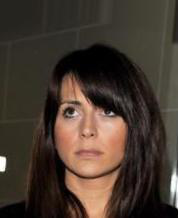

Centroid of cluster 1


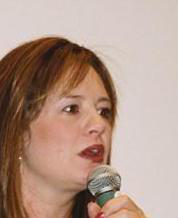

Centroid of cluster 2


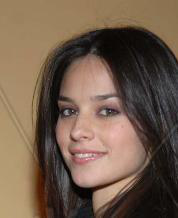

Centroid of cluster 3


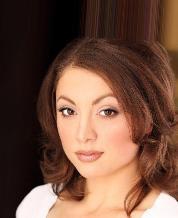

Centroid of cluster 4


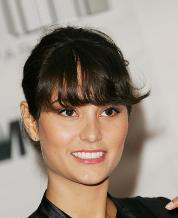

In [63]:
for i in set(kmeans.labels_):
    # select elements of the cluster
    elements = to_cluster[kmeans.labels_ == i]
    
    centroid = kmeans.cluster_centers_[i]
 
    minimum = elements[np.linalg.norm(elements - centroid, axis = 1).argmin()]

    to_print = np.linalg.norm(space - minimum, axis = 1).argmin()
    
    file = df.loc[to_print, "image_id"]
    image = skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
    
    im = Image.fromarray(image)

    #im.save(path)
    print("Centroid of cluster {}".format(i))
    display(im)
    